# Assignment 2: Final Analysis of CitiBike Data

## Define idea and parameters of data analysis:

**Idea:** Does the trip distance distribution of a CitiBike users vary with age?

**Define trip distance:** The distance in miles between start station and end station locations.

**Define age groups:**

* Y = young riders: y >= 1980 (millenials)

* X = total riders: 1951 > x < 1980  (working population, not typically retired)

**Define long distance trips:**

* L = trips > 3 miles from start to end station

* S = trips <= 3 miles from start to end station

## State Hypotheses:

### Null Hypothesis: 

The ratio of long distance trips by young riders to all distance trips by young riders is less than or equal to the ratio of long distance trips by the rest of the population to all distance trips by the rest of the population.

$$Ly/Sy-Lx/Sx<=0$$

### Alternative Hypothesis:

The ratio of long distance trips by young riders to all distance trips by young riders is greater than the ratio of long distance trips by the rest of the population to all distance trips by the rest of the population.

$$Ly/Sy-Lx/Sx>0$$

**Significance level:** 0.05

## Set up the work for data-driven inference based on CitiBike data.

In [90]:
#import data to workspace using PUIDATA
#set working environment by importing packages
import os
import pylab as pl
import pandas as pd
import scipy.stats
import geopy # THIS PACKAGE DOES NOT COME WITH ANACONDA, INSTALL FIRST
from geopy.distance import vincenty

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [51]:
#make sure PUIDATA is set as an environmental variable
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

In [52]:
#retrieve data
PUIDATA = os.getenv("PUIDATA")
PUIDATA = "/home/cusp/kal573/PUIdata"
data = pd.read_csv(PUIDATA + "/201606-citibike-tripdata.csv")
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


In [53]:
#explore data: statistics
#this reveals that the majority of the data lies near our interest: millenials
datamean = data["birth year"].mean()
datamedian = data["birth year"].median()
print(datamean)
print(datamedian)

1977.6594183
1980.0


In [54]:
# remove unneeded data before proceeding with analysis
# this will allow the script to run faster
data = data.loc[:,["start station latitude","start station longitude","end station latitude", "end station longitude", "birth year" ]]
data.head()

,start station latitude,start station longitude,end station latitude,end station longitude,birth year
0,40.734011,-74.002939,40.758985,-73.993800,1972.0
1,40.719009,-73.958525,40.721533,-73.957824,1967.0
2,40.764618,-73.987895,40.763441,-73.982681,1989.0
3,40.757148,-73.972078,40.720196,-73.989978,1991.0
4,40.729039,-73.994046,40.734546,-73.990741,1989.0


In [55]:
#add new columns to begin calculating distance using decimal degrees
#distance = (latitude, longitude of end station) subtracted from (latitude, longitude of start station)
data.loc[:,"start_location"] = "(" + data["start station latitude"].map(str) + "," + " " + data["start station longitude"].map(str) + ")"
data.head()

data.loc[:,"stop_location"] = "(" + data["end station latitude"].map(str) + "," + " " + data["end station longitude"].map(str) + ")"
data.loc[:,"start_location"] = data.loc[:,"start_location"].map(eval)
data.loc[:,"stop_location"] = data.loc[:,"stop_location"].map(eval)
data.head()


,start station latitude,start station longitude,end station latitude,end station longitude,birth year,start_location,stop_location
0,40.734011,-74.002939,40.758985,-73.993800,1972.0,"(40.73401143, -74.00293877)","(40.758984814, -73.9937996864)"
1,40.719009,-73.958525,40.721533,-73.957824,1967.0,"(40.7190095, -73.95852515)","(40.72153267, -73.95782357)"
2,40.764618,-73.987895,40.763441,-73.982681,1989.0,"(40.76461837, -73.98789473)","(40.76344058, -73.98268129)"
3,40.757148,-73.972078,40.720196,-73.989978,1991.0,"(40.75714758, -73.97207836)","(40.72019576, -73.98997825)"
4,40.729039,-73.994046,40.734546,-73.990741,1989.0,"(40.72903917, -73.99404649)","(40.73454567, -73.99074142)"


In [56]:
# eliminate data entries that fall outside of our scope (born after 1951)
newdata = data[data["birth year"] > 1951]
len(newdata)

1240530

## find distance from decimal degree data using geopy

In [57]:
#create new distance column and populate it
#first define a function that uses vincenty (from geopy) to find distance in miles

def dist_newdata(df):
    '''
    function to return start and stop locations in miles for all rows
    
    output will be used to calculate trip distance
    
    '''
    return vincenty(df["start_location"],df["stop_location"]).miles


In [58]:
#create new column titled 'distance' and run the function
#BE ADVISED: THIS MAY TAKE UP TO 10 MINUTES TO RUN COMPLETELY
newdata["distance"] = newdata.apply(dist_newdata, axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [59]:
#check to see if the function worked properly
newdata.head()

,start station latitude,start station longitude,end station latitude,end station longitude,birth year,start_location,stop_location,distance
0,40.734011,-74.002939,40.758985,-73.993800,1972.0,"(40.73401143, -74.00293877)","(40.758984814, -73.9937996864)",1.788728
1,40.719009,-73.958525,40.721533,-73.957824,1967.0,"(40.7190095, -73.95852515)","(40.72153267, -73.95782357)",0.177958
2,40.764618,-73.987895,40.763441,-73.982681,1989.0,"(40.76461837, -73.98789473)","(40.76344058, -73.98268129)",0.285343
3,40.757148,-73.972078,40.720196,-73.989978,1991.0,"(40.75714758, -73.97207836)","(40.72019576, -73.98997825)",2.717342
4,40.729039,-73.994046,40.734546,-73.990741,1989.0,"(40.72903917, -73.99404649)","(40.73454567, -73.99074142)",0.417694


In [60]:
#explore new data column
distance_mean = newdata["distance"].mean()
print(distance_mean)

1.16313687622


In [61]:
#visualize data, distance less than 20 miles
#this was used as a cutoff for extraneous values that would affect our analysis
data_cut = newdata[newdata["distance"] < 20]

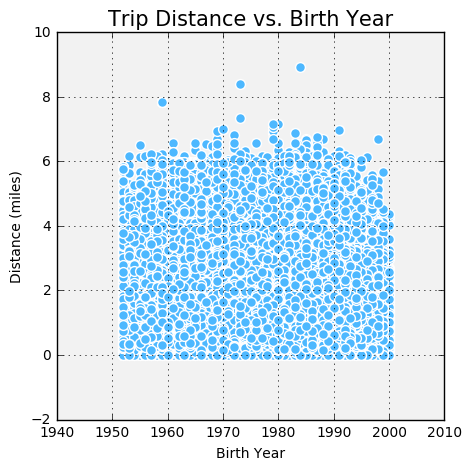

In [62]:
#plot birth year versus distance for exploration
fig = pl.figure(figsize(5,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
pl.scatter(data_cut["birth year"], data_cut["distance"], s=50, facecolors='#4db8ff', edgecolors='white')
pl.ylabel('Distance (miles)')
pl.xlabel('Birth Year')
pl.grid()
pl.title("Trip Distance vs. Birth Year", size=15)


In [63]:
#create new dataset of just 'long distance' trips greater than 3 miles from start to end station
data_3 = data_cut[data_cut["distance"] >3]

In [64]:
#group data by birth year of just data_3 dataset to see count distribution for long distance trips
count_per_birth_year_long = data_3["distance"].groupby(data_3["birth year"]).count()

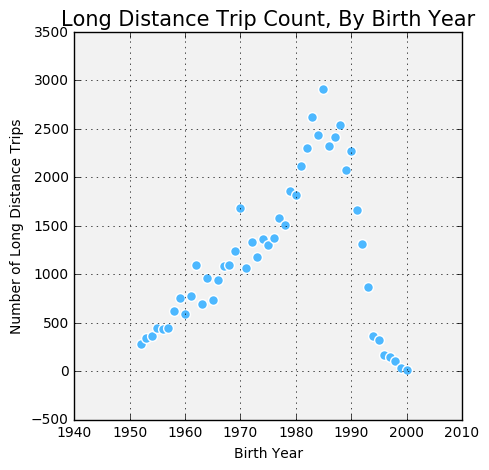

In [65]:
#plot trip counts per birth year
fig = pl.figure(figsize(5,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
pl.scatter(count_per_birth_year_long.index, count_per_birth_year_long.values, s=50, facecolors='#4db8ff', edgecolors='white')
pl.ylabel('Number of Long Distance Trips')
pl.xlabel('Birth Year')
pl.grid()
pl.title("Long Distance Trip Count, By Birth Year", size=15)

In [66]:
#group data by birth year, all trips 
count_per_birth_year_all = data_cut["distance"].groupby(data_cut["birth year"]).count()

#normalize data for long trip analysis
count_per_birth_normalized = count_per_birth_year_long / count_per_birth_year_all

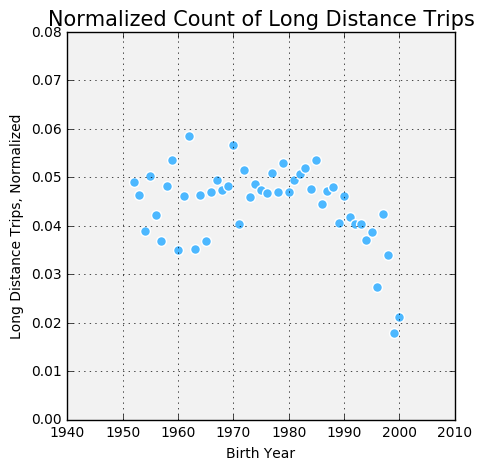

In [67]:
#plot normalized data
fig = pl.figure(figsize(5,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
pl.scatter(count_per_birth_normalized.index, count_per_birth_normalized.values, s=50, facecolors='#4db8ff', edgecolors='white')
pl.ylabel('Long Distance Trips, Normalized')
pl.xlabel('Birth Year')
pl.grid()
pl.title("Normalized Count of Long Distance Trips", size=15)

In [41]:
#export data to csv for future analysis
data_cut.to_csv("citibike_clean_data.csv")

In [68]:
#define dataset of just millenials
mill = data_cut[data_cut["birth year"] >= 1980]
mill.head()

,start station latitude,start station longitude,end station latitude,end station longitude,birth year,start_location,stop_location,distance
2,40.764618,-73.987895,40.763441,-73.982681,1989.0,"(40.76461837, -73.98789473)","(40.76344058, -73.98268129)",0.285343
3,40.757148,-73.972078,40.720196,-73.989978,1991.0,"(40.75714758, -73.97207836)","(40.72019576, -73.98997825)",2.717342
4,40.729039,-73.994046,40.734546,-73.990741,1989.0,"(40.72903917, -73.99404649)","(40.73454567, -73.99074142)",0.417694
6,40.752996,-73.987216,40.714948,-74.002345,1986.0,"(40.75299641, -73.98721619)","(40.71494807, -74.00234482)",2.742892
7,40.750200,-73.990931,40.732233,-73.988900,1986.0,"(40.75019995, -73.99093085)","(40.73223272, -73.98889957)",1.244361


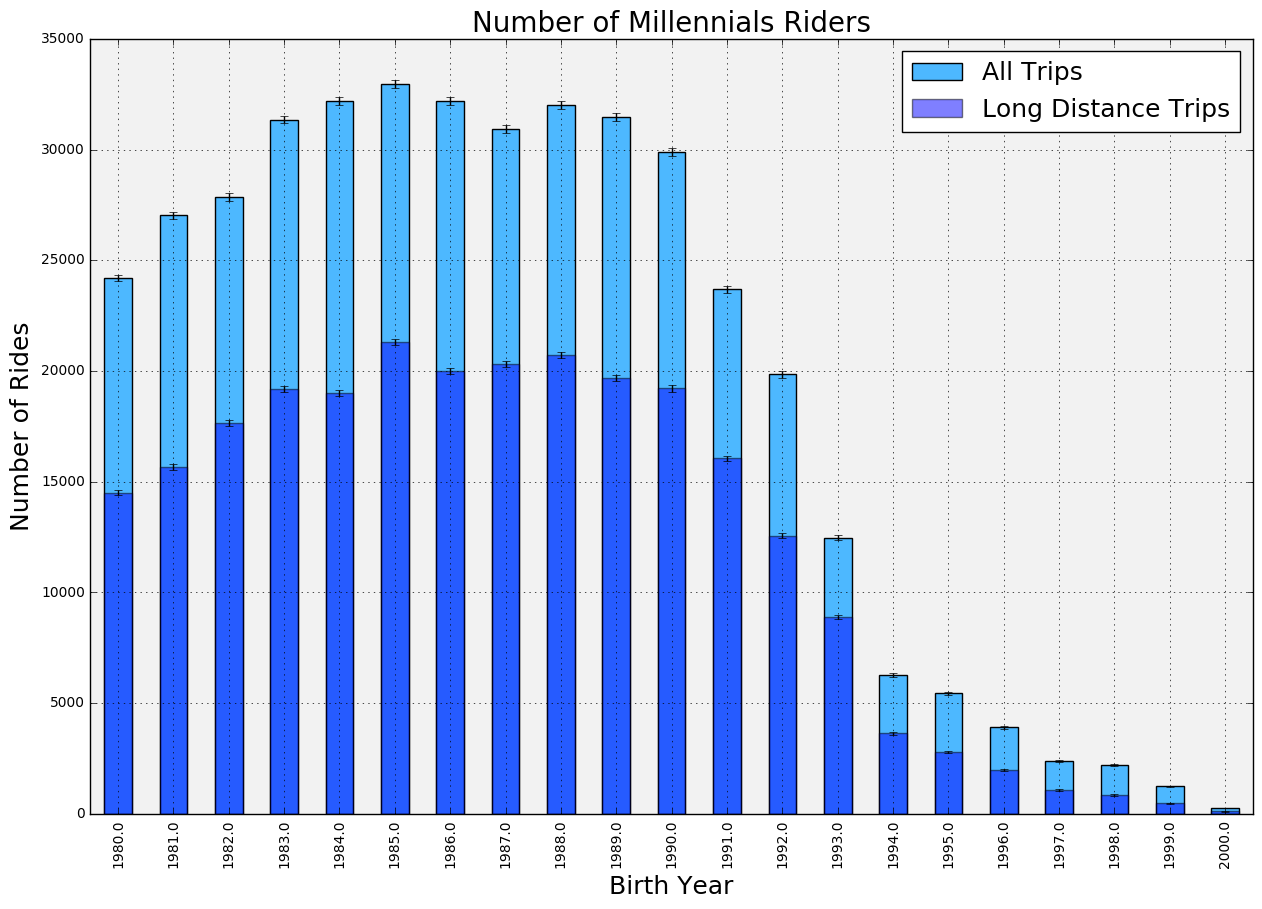

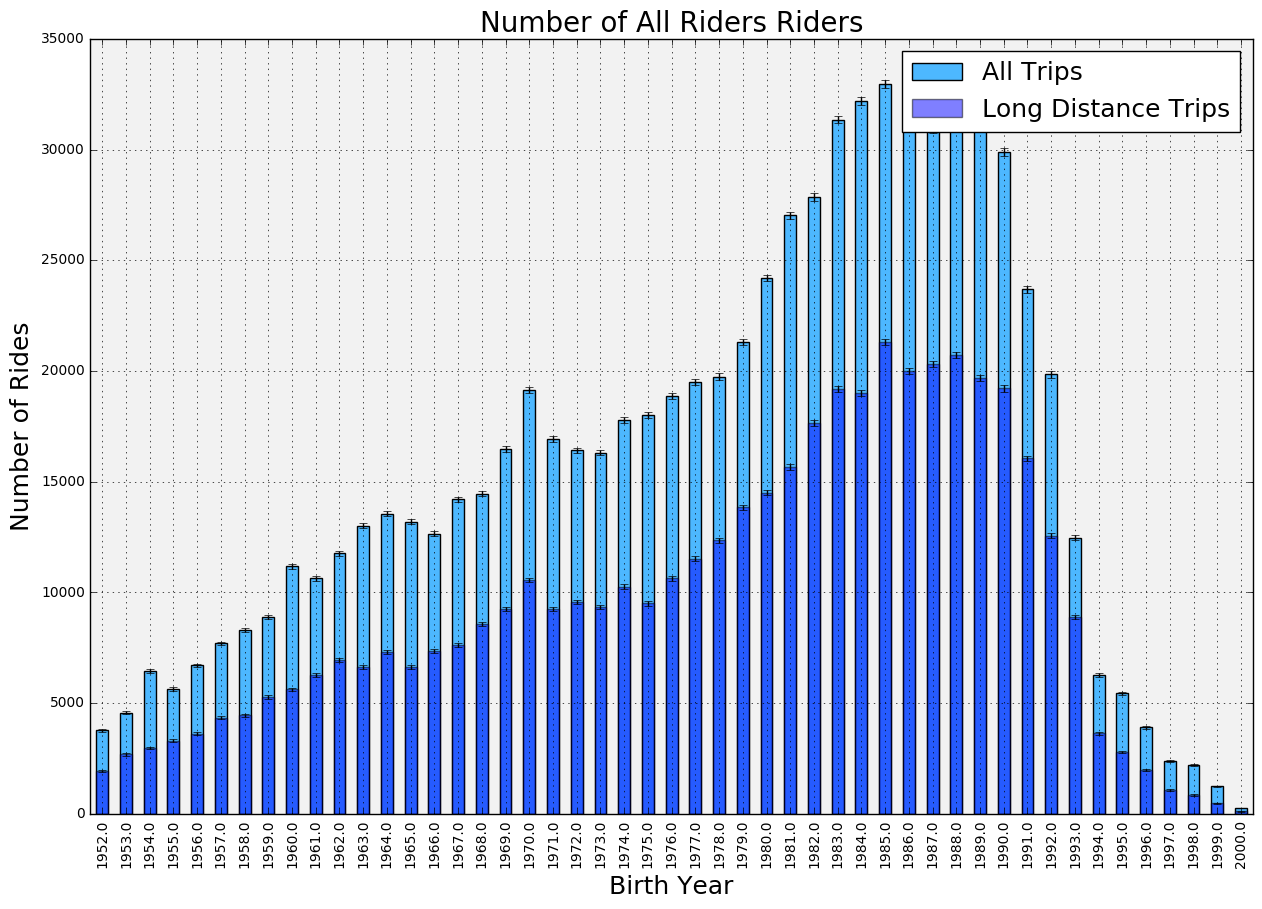

In [69]:
# initial data visualizations: boxplots
avg_dis = data_cut.distance.mean()

def plot_vs(m, group):
    '''
    This function returns boxplots of the CitiBike Data, comparing all trips with long distance trips for different age groups
   
    '''
    
    fig = pl.figure(figsize(15, 10))
    ax = fig.add_subplot(111)
    ax.set_axis_bgcolor('#f2f2f2')
    counts_all = m["birth year"][m.distance <= avg_dis].groupby(m["birth year"]).count()
    norm_all = 1
    error_all = np.sqrt(counts_all)
    ax=((counts_all) / norm_all).plot(kind="bar",color='#4db8ff',  yerr=[
                ((error_all) / norm_all, (error_all) / norm_all)], label='All Riders')

    counts_l = m["birth year"][m.distance > avg_dis].groupby(m["birth year"]).count()
    norm_l = 1
    error_l = np.sqrt(counts_l)
    ((counts_l) / norm_l).plot(kind="bar", alpha=0.5, yerr=[((error_l) / norm_l, (error_l) / norm_l)], label='Long Distance Trips')
    ax.set_ylabel ("Number of Rides", fontsize = 18)
    ax.set_ylim([0, 35000])
    ax.set_xlabel ("Birth Year", fontsize = 18)
    pl.legend(['All Trips','Long Distance Trips'],fontsize=18)
    pl.title("Number of " + group + " Riders", fontsize = 20)
    pl.grid()
    pl.show()
    return counts_all,counts_l
m_all, m_long = plot_vs(mill,"Millennials")
o_all, o_long = plot_vs(data_cut,"All Riders")

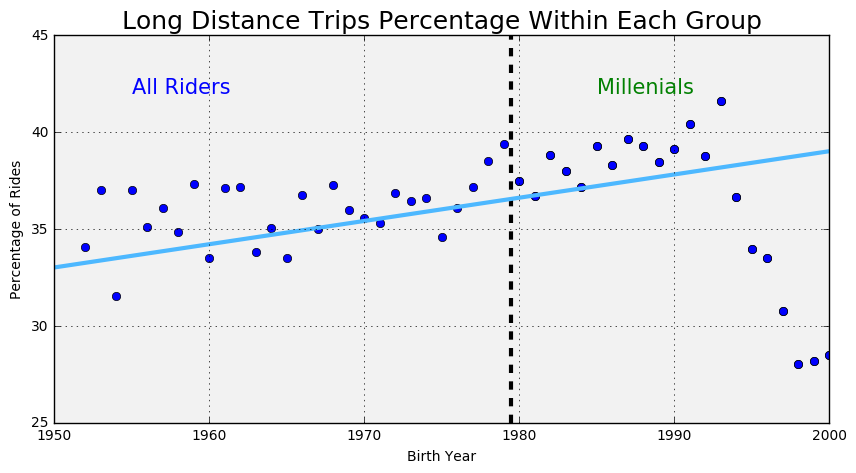

In [75]:
# plot long distance trips, by group
m_percentage = m_long/(m_long+m_all) * 100
o_percentage = o_long/(o_long+o_all) * 100

fig=pl.figure(figsize(10,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
ax.plot(m_percentage.index,m_percentage.values, 'o', color = "green", alpha = 0.8)
ax.plot(o_percentage.index,o_percentage.values,'o')
pl.plot([1979.5, 1979.5], [25,45], '--', color = 'black', lw = 3)
pl.plot([1950, 2000], [33, 39], color = '#4db8ff', lw = 3)
ax.set_ylabel("Percentage of Rides", fontsize = 10)
ax.set_xlabel("Birth Year", fontsize = 10)

pl.text(1985,42,r'Millenials', color='green', size = 15)
pl.text(1955,42,r'All Riders', color='blue', size = 15)
pl.title("Long Distance Trips Percentage Within Each Group", size = 18)
pl.grid()

## Analysis: Ratio Distributions and Z Test

### This is the beginning of Assignment 6, after receiving peer feedback

In [78]:
# create variables for each variable for hypothesis testing

allriders_long = count_per_birth_year_long
allriders_all = count_per_birth_year_all

youngriders_long = allriders_long[allriders_long.index>=1980]
youngriders_all = allriders_all[allriders_all.index>=1980]


In [79]:
# ratio for young riders
young_ratio = youngriders_long / youngriders_all
young_ratio

birth year
1980.0    0.047003
1981.0    0.049546
1982.0    0.050662
1983.0    0.051874
1984.0    0.047606
1985.0    0.053641
1986.0    0.044475
1987.0    0.047107
1988.0    0.048054
1989.0    0.040592
1990.0    0.046236
1991.0    0.041847
1992.0    0.040336
1993.0    0.040434
1994.0    0.037022
1995.0    0.038793
1996.0    0.027418
1997.0    0.042327
1998.0    0.034031
1999.0    0.017950
2000.0    0.021108
Name: distance, dtype: float64

In [80]:
all_ratio = allriders_long / allriders_all
all_ratio

birth year
1952.0    0.048934
1953.0    0.046451
1954.0    0.038845
1955.0    0.050179
1956.0    0.042219
1957.0    0.036886
1958.0    0.048219
1959.0    0.053598
1960.0    0.035088
1961.0    0.046057
1962.0    0.058610
1963.0    0.035244
1964.0    0.046283
1965.0    0.036850
1966.0    0.047024
1967.0    0.049517
1968.0    0.047462
1969.0    0.048285
1970.0    0.056672
1971.0    0.040457
1972.0    0.051424
1973.0    0.046020
1974.0    0.048545
1975.0    0.047397
1976.0    0.046685
1977.0    0.050808
1978.0    0.046910
1979.0    0.052913
1980.0    0.047003
1981.0    0.049546
1982.0    0.050662
1983.0    0.051874
1984.0    0.047606
1985.0    0.053641
1986.0    0.044475
1987.0    0.047107
1988.0    0.048054
1989.0    0.040592
1990.0    0.046236
1991.0    0.041847
1992.0    0.040336
1993.0    0.040434
1994.0    0.037022
1995.0    0.038793
1996.0    0.027418
1997.0    0.042327
1998.0    0.034031
1999.0    0.017950
2000.0    0.021108
Name: distance, dtype: float64

In [81]:
len(young_ratio)

21

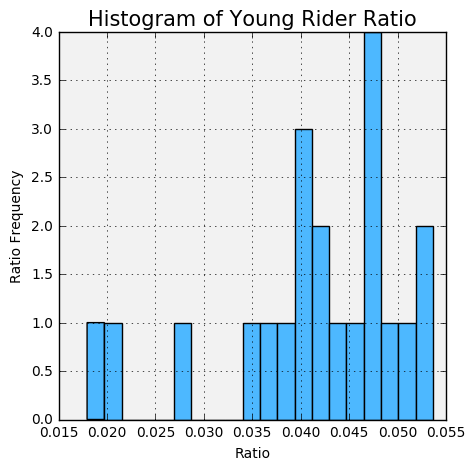

In [85]:
# plot histogram of young rider ratio to explore distribution
fig = pl.figure(figsize(5,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
young_hist = pl.hist(young_ratio, bins=20, facecolor='#4db8ff')
pl.ylabel('Ratio Frequency')
pl.xlabel('Ratio')
pl.grid()
pl.title("Histogram of Young Rider Ratio", size=15)

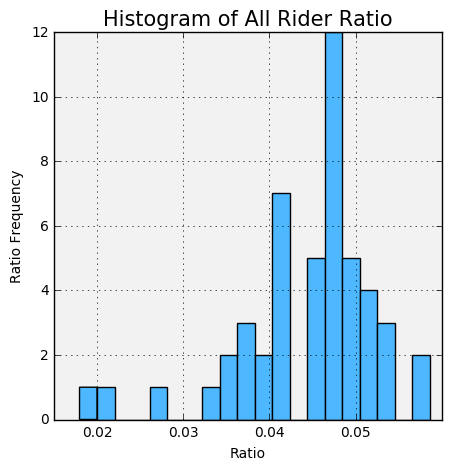

In [86]:
# plot histogram of all rider ratio to explore distribution
fig = pl.figure(figsize(5,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
all_hist = pl.hist(all_ratio, bins=20, facecolor='#4db8ff')
pl.ylabel('Ratio Frequency')
pl.xlabel('Ratio')
pl.grid()
pl.title("Histogram of All Rider Ratio", size=15)

### Perform Z Test:

In [87]:
# find means for z test
young_mean = young_ratio.mean()
all_mean = all_ratio.mean()

# find standard deviations for z test
young_std = young_ratio.std()
all_std = all_ratio.std()


In [88]:
Z = (young_mean - all_mean) / (young_std / np.sqrt(len(young_ratio)))
print Z

-1.42813406171


In [89]:
alpha = .05
print("Z score for our analysis of young riders who take long trips: {0:.1f}".format(Z))
print("This means we are {0:.1f} standard deviations away".format(Z))
print("from the mean of all the CitiBike riders who take long trips\n\n")
if Z < -2:
    result = "IS REJECTED"
else: 
    result = "CANNOT BE REJECTED"

print("The Null Hypothesis that the new route does not improve commuting")
print("{0:s} at the {1:.1f}% significance level".format(result, 100*(1-alpha)))

Z score for our analysis of young riders who take long trips: -1.4
This means we are -1.4 standard deviations away
from the mean of all the CitiBike riders who take long trips


The Null Hypothesis that the new route does not improve commuting
CANNOT BE REJECTED at the 95.0% significance level


In [92]:
# find p-value and make hypothesis conclusions
pvalue = (1 - scipy.stats.norm.cdf(Z))
print pvalue

0.92337336242


### Z Test Results:

The p-value allows us to interpret our results in terms of the probability to reject the null hypothesis. Our Z score (-1.4) is less than our p-value (-1.96) so we cannot reject the null hypothesis at a 95% significance level.

According to this analysis of the CitiBike data, the ratio of long distance trips for young riders is not greater than the ratio of long distance trips for all riders.